In [1]:
# SET THE WORKING DIRECTORY FOR THIS ASSIGNMENT

%cd 'D:\Masters\S1Class\AdvResMeth8160\Hw02'

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "'D:\\Masters\\S1Class\\AdvResMeth8160\\Hw02'"
d:\Masters\S1Class\AdvResMeth8160\Hw02


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.device_count()
print(torch.__version__)

cuda:0
2.0.0


In [3]:
# IMPORT NEEDED MODULES

import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [4]:
class TrafficDataset(Dataset):
  def __init__(self, pkl_path, window, horizon):
    self.pkl_path = pkl_path
    self.window = window
    self.horizon = horizon


   # RESHAPE THE DATAFRAME
    df = pd.read_pickle(self.pkl_path)
    reshaped_df = pd.DataFrame()
    df['time'] = df['time'].apply(lambda x: int(datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").timestamp()))
    reshaped_df['TIME'] = df.time.unique()
    for seg in df.segmentID.unique():
        column =df[df['segmentID'] == seg][['time','TrafficIndex_GP']].drop_duplicates(subset=['time'])
        column.columns = ['TIME', str(seg)]
        reshaped_df = reshaped_df.join(column.set_index('TIME'), on='TIME')
    reshaped_df = reshaped_df.set_index('TIME')
    reshaped_df = reshaped_df.fillna(0)
    # print(reshaped_df)


    self.inputs = []
    self.outputs = []
    times = reshaped_df.index
    
    for column in reshaped_df.columns:
       for t in range(0, len(times) - (self.window + self.horizon)):
          w = times[t : t + self.window]
          x_list = []
          for i in range (0, self.window):
            x_list.append(int(column))
          x = x_list
          y = reshaped_df[str(column)][t: t + self.window].values
          wxy_cat = np.dstack([w,x,y])
          self.inputs.append(wxy_cat)
          z = reshaped_df[str(column)][self.window + t: self.window + t + self.horizon].values
          self.outputs.append(z)
    # print(len(self.inputs))
    # print(len(self.outputs))
       

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self,idx):
    X = torch.tensor(self.inputs[idx],dtype=torch.float32)
    y=torch.tensor(self.outputs[idx],dtype=torch.float32)
    return {'inputs':X,'outputs':y}

class ToTensor(object):
    def __call__(self, bs,window, horizon, sample):
        input, output = sample['inputs'], sample['outputs']

        return {'inputs': torch.tensor(np.array(input),dtype=torch.float32),
                'outputs': torch.tensor(np.array(output),dtype=torch.float32)}

In [5]:
window = 36; horizon = 12
traffic_obj_train = TrafficDataset('D:\\Masters\\S1Class\\AdvResMeth8160\\Hw02\\tps_df.pkl', window, horizon)

In [6]:
bs = 5000
dataloader_train = DataLoader(traffic_obj_train, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

In [7]:
class MyLSTM(nn.Module):
  # build a constructor to define the inputs for the rnn module
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(MyLSTM,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers
    # self.embedding_layer = nn.Embedding(23, 1)
    self.relu = nn.ReLU()

    #batch_first means reshaping input to N x T x D
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first= True)
    
    self.fc = nn.Linear(self.M, self.K)
    
  def forward(self, X):
    # initialize hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out,_ = self.rnn(X,(h0,c0))

    # we only want the hidden state at the final step
    # out is now N x M
    out = self.fc(out[:,-1,:])

    return out

In [10]:
model = MyLSTM(n_inputs=3, n_hidden=1, n_rnnlayers=1, n_outputs=12)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 10
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(traffic_obj_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    if i_batch ==1:
      print (loss)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    

  # for i_test,sample_test in enumerate(traffic_obj_test):
  #     sample_test = ts(bs,window, horizon, sample_batched)
  #     outputs = model(sample_test['inputs'].to(device))
  #     test_loss = criterion(outputs, sample_test['outputs'].to(device))
  #     test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  # mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')
    # Testing Loss: {np.mean(test_losses):.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(1.2860, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|█         | 1/10 [1:00:31<9:04:47, 3631.97s/it]

Epoch 1/10, Training Loss: 0.0107
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|██        | 2/10 [2:01:02<8:04:08, 3631.05s/it]

Epoch 2/10, Training Loss: 0.0104
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|███       | 3/10 [3:01:36<7:03:45, 3632.25s/it]

Epoch 3/10, Training Loss: 0.0103
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|████      | 4/10 [4:02:03<6:03:01, 3630.26s/it]

Epoch 4/10, Training Loss: 0.0103
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 50%|█████     | 5/10 [5:02:33<5:02:31, 3630.25s/it]

Epoch 5/10, Training Loss: 0.0102
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 60%|██████    | 6/10 [6:03:07<4:02:06, 3631.67s/it]

Epoch 6/10, Training Loss: 0.0102
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 7/10 [7:04:05<3:02:00, 3640.14s/it]

Epoch 7/10, Training Loss: 0.0102
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 8/10 [8:05:07<2:01:34, 3647.09s/it]

Epoch 8/10, Training Loss: 0.0102
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 9/10 [9:05:56<1:00:47, 3647.84s/it]

Epoch 9/10, Training Loss: 0.0102
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 10/10 [9:48:27<00:00, 3530.76s/it] 

Epoch 10/10, Training Loss: 0.0102


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

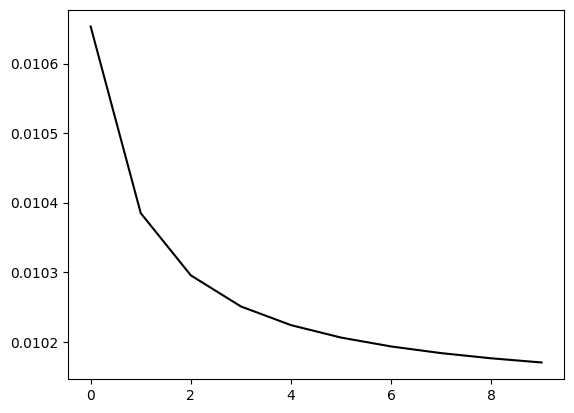

In [12]:
plt.plot(mean_loss, 'k', label = 'training')
plt.legend

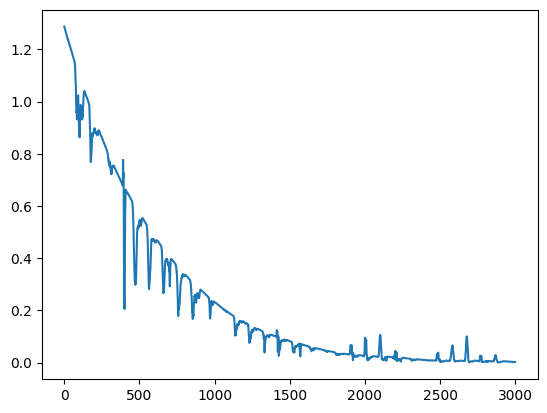

In [15]:
plt.plot(losses[0:3000])

In [14]:
torch.save(model.state_dict(), 'HW02LSTM10E.pt')